# Linear Regression with PEST++ iES

Test notebook to compare the PEST++ iES outcomes for a linear regression problem where the confidence intervals can be computed exact. 

## Setup

### Packages

In [1]:
import json
from dataclasses import dataclass, field
from pathlib import Path
from typing import Any, Literal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyemu
import scipy as sp
import xarray as xr
from cmcrameri import cm as cmc
from numpy.typing import NDArray
from pastas import show_versions
from pastas_plugins import show_plugin_versions
from pastas_plugins.pest import PestIesSolver
from pyemu.utils.get_pestpp import run_main as get_pestpp

print("Pyemu version:", pyemu.__version__)
show_versions()
show_plugin_versions()

Pyemu version: 1.3.8+54.g41adeeb6
Pastas version: 1.11.0
Python version: 3.13.5
NumPy version: 2.2.5
Pandas version: 2.2.3
SciPy version: 1.15.2
Matplotlib version: 3.10.1
Numba version: 0.61.2
pastas_plugins version      : 0.3.2
- cross_correlation version : not available (check dependencies)
- modflow version           : 0.3.0
- pest version              : 0.0.3
- reservoirs version        : 0.1.0
- responses version         : 0.2.0

Note: To install missing dependencies use `pip install pastas-plugins[<plugin-name>]`


### Linear regression model

Setup of the model might be a bit weird but this way we can easily use the PestIesSolver in Pastas Plugins. The PestIesSolver allows for the pypestworker etc.

In [2]:
@dataclass
class LinRegModel:
    y: pd.Series = field(repr=False)

    def __post_init__(self):
        self.x: NDArray[float] = self.y.index.values
        p0_mean = np.mean(self.y.values)
        p1_ini = (y.iat[-1] - y.iat[0]) / (x[-1] - x[0])  # initial estimate slope
        self._parameters: pd.DataFrame = pd.DataFrame(
            [
                [
                    p0_mean,
                    np.min(self.y.values) - p0_mean / 4,
                    np.max(self.y.values) + p0_mean / 4,
                    np.nan,
                    True,
                ],
                [p1_ini, p1_ini - p1_ini * 2.0, p1_ini + p1_ini * 2.0, np.nan, True],
            ],
            index=pd.Index(
                [
                    "p_0",
                    "p_1",
                ],
                name="parnames",
            ),
            columns=["initial", "pmin", "pmax", "optimal", "vary"],
        )

    @property
    def p_0(self):
        return (
            self._parameters.at["p_0", "initial"]
            if np.isnan(self._parameters.at["p_0", "optimal"])
            else self._parameters.at["p_0", "optimal"]
        )

    @property
    def p_1(self):
        return (
            self._parameters.at["p_1", "initial"]
            if np.isnan(self._parameters.at["p_1", "optimal"])
            else self._parameters.at["p_1", "optimal"]
        )

    @property
    def parameters(self):
        return self._parameters

    def observations(self):
        return self.y

    def simulate(self):
        y = self.p_0 + self.p_1 * self.x
        return pd.Series(y, index=pd.Index(self.x, name="x"), name="Simulated")

    @staticmethod
    def synthetic(
        x: NDArray[float],
        p_0: float,
        p_1: float,
        noise_std: float = 0.0,
        noise_ccoeff: float = 0.0,
    ):
        """Generate synthetic linear data with optional noise.

        Parameters
        ----------
        x : NDArray[float]
            Input x values.
        p_0 : float
            Intercept of the linear model.
        p_1 : float
            Slope of the linear model.
        noise_std : float, optional
            Standard deviation of the Gaussian noise to be added, by default 0.0.
        noise_ccoeff : float, optional
            Correlation coefficient for autocorrelated noise (between -1 and 1), by default 0.0.

        Returns
        -------
        pd.Series
            Synthetic y values with optional noise.
        """
        y = p_0 + p_1 * x
        if noise_std > 0.0:
            drng = np.random.default_rng(pyemu.en.SEED)  # set seed
            noise = drng.normal(loc=0.0, scale=noise_std, size=len(y))
            if noise_ccoeff != 0.0:
                sige = np.sqrt(1 - noise_ccoeff**2) * noise_std
                e = drng.normal(loc=0.0, scale=sige, size=len(y))
                for j in range(1, len(y)):
                    noise[j] = noise_ccoeff * noise[j - 1] + e[j]

            y += noise
        return pd.Series(y, index=pd.Index(x, name="x"))

    def set_parameter(
        self,
        name: str,
        initial: float | None = None,
        pmin: float | None = None,
        pmax: float | None = None,
        optimal: float | None = None,
        vary: bool | None = None,
    ) -> None:
        if initial is not None:
            self._parameters.loc[name, "initial"] = initial
        if pmin is not None:
            self._parameters.loc[name, "pmin"] = pmin
        if pmax is not None:
            self._parameters.loc[name, "pmax"] = pmax
        if optimal is not None:
            self._parameters.loc[name, "optimal"] = optimal
            # setattr(self, name, optimal)
        if vary is not None:
            self._parameters.loc[name, "vary"] = vary

    def add_solver(self, solver: Any):
        self.solver = solver
        solver.set_model(self)

    def solve(self) -> None:
        self.solver.solve()

    def to_file(self, path: Path) -> None:
        # write dummy model to emulate pastas
        with open(path, "w") as f:
            f.write("Dummy model file\n")
            f.write(f"p_0: {self.p_0}\n")
            f.write(f"p_1: {self.p_1}\n")

    def rss(self, sim: pd.Series | None = None) -> float:
        if sim is None:
            sim = self.simulate()
        residuals = self.y - sim
        return float(np.sum(residuals**2))

### Linear regression solver

Linear regression solver from SciPy (`scipy.stats.linregress`) which can compute the true confidence intervals and everything.

In [3]:
@dataclass
class LinRegSolver:
    """https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html"""

    model: None | LinRegModel = None

    def set_model(self, model: LinRegModel) -> None:
        self.model = model

    @staticmethod
    def linregress(x: NDArray[float], y: NDArray[float]) -> sp.optimize.OptimizeResult:
        res = sp.stats.linregress(x=x, y=y)
        return res

    def solve(self) -> None:
        if self.model is None:
            raise ValueError("No model assigned to solver.")
        res = self.linregress(x=self.model.x, y=self.model.y)
        self.res = res
        self.model.set_parameter(name="p_1", optimal=res.slope)
        self.model.set_parameter(name="p_0", optimal=res.intercept)

    def critical_t(self, alpha: float = 0.05) -> float:
        """Calculate the critical t-value for the slope and intercept.

        Parameters
        ----------
        alpha : float, optional
            Significance level, by default 0.05

        Returns
        -------
        float
            Critical t-value
        """
        n = len(self.model.x)
        dof = n - 2  # degrees of freedom
        # alpha = 0.05 # probability of confidence interval
        tinv = abs(
            sp.stats.distributions.t.ppf(alpha / 2.0, dof)
        )  # Two-sided inverse Students t-distribution
        return tinv

    def ci(self, alpha: float = 0.05) -> tuple[float, float]:
        """Calculate the confidence interval for the slope and intercept.

        Parameters
        ----------
        alpha : float, optional
            Significance level, by default 0.05

        Returns
        -------
        tuple[float, float]
            Confidence interval for intercept and slope (p_0_ci, p_1_ci)
        """
        tinv = self.critical_t(alpha=alpha)
        p_0_ci = tinv * self.res.intercept_stderr
        p_1_ci = tinv * self.res.stderr
        return p_0_ci, p_1_ci

    def ci_sim(self, alpha: float = 0.05) -> tuple[NDArray[float], NDArray[float]]:
        """Calculate the confidence interval for the simulated values.
        https://rpubs.com/aaronsc32/regression-confidence-prediction-intervals

        Parameters
        ----------
        alpha : float, optional
            Significance level, by default 0.05

        Returns
        -------
        tuple[NDArray[float], NDArray[float]]
            Lower and upper confidence interval for simulated values
        """
        x = self.model.x
        n = len(x)
        se = np.sqrt(self.model.rss() / (n - 2)) * np.sqrt(
            1 / n + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)
        )

        y_fit = self.model.simulate()
        tinv = self.critical_t(alpha=alpha)
        lb = y_fit - tinv * se
        ub = y_fit + tinv * se

        # Compute lower and upper bounds for simulated values using the confidence intervals
        # p0, p1 = self.res.intercept, self.res.slope
        # p_0_ci, p_1_ci = self.ci(alpha=alpha)
        # b0 = self.model.synthetic(self.model.x, p0 - p_0_ci, p1 - p_1_ci).rename("--")
        # b1 = self.model.synthetic(self.model.x, p0 + p_0_ci, p1 + p_1_ci).rename("++")
        # b2 = self.model.synthetic(self.model.x, p0 - p_0_ci, p1 + p_1_ci).rename("-+")
        # b3 = self.model.synthetic(self.model.x, p0 + p_0_ci, p1 - p_1_ci).rename("+-")
        # lb = pd.concat([b0, b1, b2, b3], axis=1).min(axis=1)
        # ub = pd.concat([b0, b1, b2, b3], axis=1).max(axis=1)

        return lb, ub

### PEST++ iES PostProcessor

Load all iES results in one object (xarray.Dataset).

In [4]:
class PestIesPostProcessor:
    """PEST++ iES postprocessing class"""

    def __init__(self, path: str | Path):
        """Initialize the PestIesPostProcessor with a path."""
        self.path = Path(path).resolve()

    def __repr__(self):
        return f"PestIesPostProcessor(path={self.path})"

    @property
    def files(self) -> list[Path]:
        """Return all files in the path."""
        return [x for x in self.path.glob("*") if x.is_file()]

    @property
    def noptmax(self) -> int:
        """Return the maximum number of optimization iterations."""
        nopt_maxes = [x.name.split(".")[1] for x in list(self.path.glob("pest.*.*"))]
        noptmax = max([int(x) for x in nopt_maxes if x.isdigit()])
        return noptmax

    @staticmethod
    def df_to_da(df: pd.DataFrame) -> xr.DataArray:
        """Convert a DataFrame to an xarray DataArray."""
        da = xr.DataArray(
            df.values,
            coords=[df.index, df.columns],
            dims=[
                "index" if df.index.name is None else df.index.name,
                "columns" if df.columns.name is None else df.columns.name,
            ],
        )
        return da

    def _load_ensembles(self, suffix: Literal[".par.csv", ".obs.csv"]) -> xr.Dataset:
        """Load ensembles from the processed files."""
        suffix_mapping = {
            ".obs.csv": "oname",
            ".par.csv": "pname",
            ".pdc.csv": "pdcname",
        }

        das = []
        for file in self.files:
            if file.name.endswith(suffix):
                if "rejected" in file.name:
                    continue
                df = pd.read_csv(file, index_col=0)
                df.columns.name = suffix_mapping[suffix]
                iteration = int(file.name.split(".")[1])
                da = self.df_to_da(df).rename(suffix.split(".")[1])
                da = da.expand_dims(iteration=[iteration])
                das.append(da)
        return xr.concat(das, dim="iteration").sortby("iteration")

    def _load_file(self, file: Path, column_name: str) -> pd.DataFrame:
        if file not in self.files:
            raise FileNotFoundError(f"File not found: {file} in {self.path}")
        df = pd.read_csv(file, index_col=0)
        df.columns.name = column_name
        return df

    def load_parameters(self) -> xr.Dataset:
        """Load parameter ensembles from the processed files."""
        return self._load_ensembles(".par.csv")

    def load_simulations(self) -> xr.Dataset:
        """Load simulation ensembles from the processed files."""
        return self._load_ensembles(".obs.csv")

    def load_observations(self) -> xr.DataArray:
        df = self._load_file(self.path / "pest.obs+noise.csv", "oname")
        da = self.df_to_da(df).rename("observations")
        return da

    def load_weights(self) -> xr.DataArray:
        """Load weights from the processed files."""
        df = self._load_file(self.path / "pest.weights.csv", "oname")
        df.index = df.index.astype(str)
        df = df.rename(index={df.index[-1]: "base"})
        da = self.df_to_da(df).rename("weights")
        return da

    def load_phi(self) -> xr.DataArray:
        """Load phi ensembles from the processed files."""
        df = self._load_file(self.path / "pest.phi.actual.csv", "real_name")
        col_i = df.columns.to_list().index("max")  # start reading after the max column
        df = df.iloc[:, slice(col_i + 1, None)]
        da = self.df_to_da(df).rename("phi")
        return da

    def load_dataset(self, rename: bool = False) -> xr.Dataset:
        """Load the complete dataset from the processed files."""
        ds = xr.merge(
            [
                self.load_parameters(),
                self.load_simulations(),
                self.load_phi(),
                self.load_observations(),
                self.load_weights(),
            ],
            compat="override",
        )
        if rename:
            param_index = json.load((self.path / "parameter_index.json").open("r"))
            obs_index = json.load((self.path / "observation_index.json").open("r"))
            ds = ds.assign_coords(
                pname=list(param_index.values()),
                oname=[pd.Timestamp(x) for x in obs_index.values()],
            )
        return ds

## Case 1: no noise on observations

Synthetic series with no noise

In [5]:
# create synthetic data
x = np.linspace(0.0, 1.0, 101)  # x coordinates
a = 1.0  # slope
b = 5.0  # y-intercept
noise_std = 0.0  # noise level

y = LinRegModel.synthetic(p_0=b, p_1=a, x=x, noise_std=noise_std)

### Solve model

#### SciPy

In [6]:
# create a linear regression model and solve with SciPy
ml_sp = LinRegModel(y)
ml_sp.add_solver(LinRegSolver())
ml_sp.solve()
ml_sp.parameters

,initial,pmin,pmax,optimal,vary
parnames,,,,,
p_0,5.5,3.625,7.375,5.0,True
p_1,1.0,-1.000,3.000,1.0,True


Scipy finds the true parameters.

#### PEST++ iES

In [7]:
#  ies settings
weight = 1e6
num_reals = 251
noptmax = 25
pestpp_ies_options = {
    # "ies_bad_phi_sigma": 3.0,
    # "ies_multimodal_alpha": 0.15,
    # "ies_use_approx": False,
    # "ies_autoadaloc": True,
    # "ies_lambda_mults": [0.01, 0.1, 1.0, 10.0],
}

exe_name = Path("bin/pestpp-ies")
exe_name.parent.mkdir(
    parents=True, exist_ok=True
) if not exe_name.parent.exists() else None
if not exe_name.exists():
    get_pestpp(str(exe_name.parent), subset=[exe_name.name], force=True)

In [ ]:
# solve with PEST++ iES
path = Path("scenarios/linreg")
path.mkdir(parents=True, exist_ok=True) if not path.exists() else None

ml_ies = LinRegModel(y)
ies_solver = PestIesSolver(
    exe_name=exe_name,
    model_ws=path / "ies_model",
    temp_ws=path / "ies_template",
    noptmax=noptmax,
    ies_num_reals=num_reals,
    control_data={},
)
ml_ies.add_solver(ies_solver)
# run lines below to adjust pst file
ml_ies.solver.initialize()
ml_ies.solver.pf.pst.observation_data["weight"] = weight
ml_ies.solver.write_pst(ml_ies.solver.pf.pst, version=2)
ml_ies.solver.run_ensembles(
    pestpp_options=pestpp_ies_options,
    observation_noise_standard_deviation=noise_std,  # sets ies_no_noise to True if 0.0
)

# load pest ies results in an xarray dataset
ml_ies_pp = PestIesPostProcessor(ml_ies.solver.temp_ws)
ds = ml_ies_pp.load_dataset(rename=True)
ds

2025-09-30 16:30:13.621767 starting: opening PstFrom.log for logging
2025-09-30 16:30:13.622800 starting PstFrom process
2025-09-30 16:30:13.623388 starting: setting up dirs
2025-09-30 16:30:13.624525 starting: removing existing new_d '/home/vonkm/repos/pestas/src/scenarios/linreg/ies_template'


2025-09-30 16:30:13.638037 finished: removing existing new_d '/home/vonkm/repos/pestas/src/scenarios/linreg/ies_template' took: 0:00:00.013512
2025-09-30 16:30:13.638901 starting: copying original_d '/home/vonkm/repos/pestas/src/scenarios/linreg/ies_model' to new_d '/home/vonkm/repos/pestas/src/scenarios/linreg/ies_template'
2025-09-30 16:30:13.640831 finished: copying original_d '/home/vonkm/repos/pestas/src/scenarios/linreg/ies_model' to new_d '/home/vonkm/repos/pestas/src/scenarios/linreg/ies_template' took: 0:00:00.001930
2025-09-30 16:30:13.642411 finished: setting up dirs took: 0:00:00.019023
2025-09-30 16:30:13.654394 starting: adding grid type d style parameters for file(s) ['parameters_sel.csv']
2025-09-30 16:30:13.654541 starting: loading list-style /home/vonkm/repos/pestas/src/scenarios/linreg/ies_template/parameters_sel.csv
2025-09-30 16:30:13.654581 starting: reading list-style file: /home/vonkm/repos/pestas/src/scenarios/linreg/ies_template/parameters_sel.csv
2025-09-30 1

/home/vonkm/repos/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-09-30 16:30:13.692165 WARNING: add_py_function() command: run() is not being called directly



noptmax:0, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.16
binary compiled on Dec  1 2024 at 10:51:08

started at 09/30/25 16:30:13
...processing command line: ' ./pestpp-ies pest.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "pest.pst"
in directory: "/home/vonkm/repos/pestas/src/scenarios/linreg/ies_template"
on host: "asuszbs14"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' .... .

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/pytho

2025-09-30 16:30:14.361246 : trying to connect to localhost:4004...2025-09-30 16:30:14.362305 : trying to connect to localhost:4004...

2025-09-30 16:30:14.376631 : trying to connect to localhost:4004...2025-09-30 16:30:14.408039 : trying to connect to localhost:4004...
2025-09-30 16:30:14.412290 : trying to connect to localhost:4004...

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.





2025-09-30 16:30:14.432450 : trying to connect to localhost:4004...2025-09-30 16:30:14.493069 : trying to connect to localhost:4004...
2025-09-30 16:30:14.506464 : trying to connect to localhost:4004...
2025-09-30 16:30:14.625633 : connected to localhost:4004
2025-09-30 16:30:14.640401 : connected to localhost:4004
2025-09-30 16:30:14.666002 : connected to localhost:4004
2025-09-30 16:30:14.670803 : connected to localhost:4004
2025-09-30 16:30:14.694545 : connected to localhost:4004
2025-09-30 16:30:14.706940 : connected to localhost:4004
2025-09-30 16:30:14.747537 : connected to localhost:4004
2025-09-30 16:30:14.760074 : connected to localhost:4004
09/30 16:30:25 remaining file transfers: 0                                       

   251 runs complete :  0 runs failed
   0.00347 avg run time (min) : 0.193 run mgr time (min)
   8 agents connected


...saved initial obs ensemble to pest.0.obs.csv
saved par and rei files for realization BASE for iteration 0
saved par and rei files for

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/pytho

<xarray.Dataset> Size: 6MB
Dimensions:       (iteration: 26, real_name: 251, pname: 2, oname: 101)
Coordinates:
  * iteration     (iteration) int64 208B 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 25
  * real_name     (real_name) object 2kB '0' '1' '2' '3' ... '248' '249' 'base'
  * pname         (pname) <U3 24B 'p_0' 'p_1'
  * oname         (oname) datetime64[ns] 808B 1970-01-01 ... 1970-01-01T00:00...
Data variables:
    par           (iteration, real_name, pname) float64 104kB 5.516 ... 1.0
    obs           (iteration, real_name, oname) float64 5MB 5.516 5.525 ... 6.0
    phi           (iteration, real_name) float64 52kB 2.239e+13 ... 0.007603
    observations  (real_name, oname) float64 203kB 5.0 5.01 5.02 ... 5.99 6.0
    weights       (real_name, oname) float64 203kB 1e+06 1e+06 ... 1e+06 1e+06

### Results

Let's look at the performance of both models.

#### Simulated values

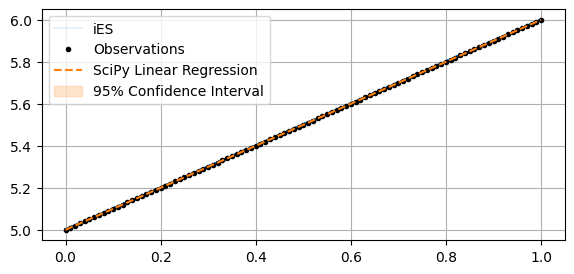

In [9]:
fig, ax = plt.subplots(figsize=(6.75, 3.0))
ax.plot(
    y.index,
    ds["obs"].isel(iteration=-1).values.T,
    color="C0",
    alpha=0.1,
    label="iES",
)
ax.plot(x, y, label="Observations", color="k", marker=".", linestyle="none")
ax.plot(
    x, ml_sp.simulate(), color="C1", linestyle="--", label="SciPy Linear Regression"
)
lower_bound, upper_bound = ml_sp.solver.ci_sim()
ax.fill_between(
    x,
    lower_bound,
    upper_bound,
    color="C1",
    alpha=0.2,
    label=f"{0.95:0.0%} Confidence Interval",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-4:], labels[-4:])
ax.grid()

SciPy is perfect on the black observations, confidence interval is the same . PEST++ iES is much wider but around the black observations.

#### Parameter estimates

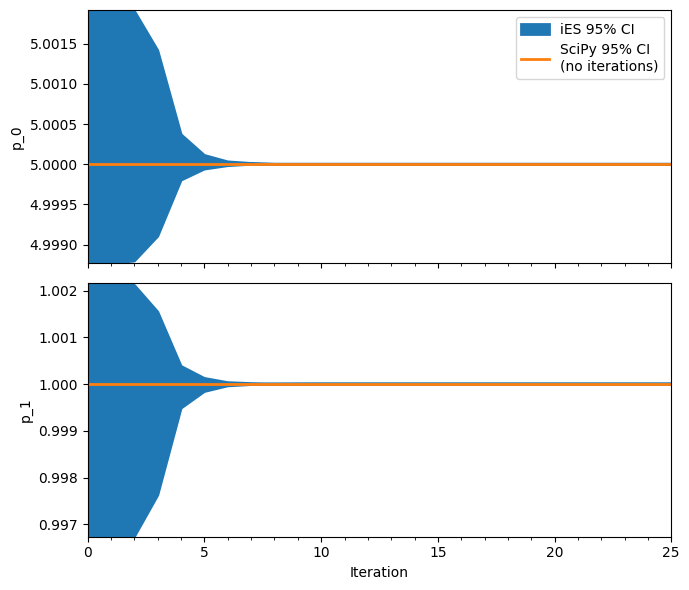

In [10]:
mosaic = [["p_0"], ["p_1"]]
f, axd = plt.subplot_mosaic(
    mosaic,
    figsize=(7.0, 6.0),
    sharex=True,
    layout="tight",
)
scipy_ci = ml_sp.solver.ci()
for i, pname in enumerate(axd):
    par = ds["par"].sel(pname=pname)
    parq = par.quantile(
        [0.025, 0.975], dim="real_name", skipna=True
    )  # .values.reshape(2, -1)
    axd[pname].fill_between(
        parq["iteration"],
        parq.values[0],
        parq.values[1],
        color="C0",
        label="iES 95% CI",
        linewidth=2.0,
    )

    scipy_opt = ml_sp.parameters.at[pname, "optimal"]
    axd[pname].axhline(
        scipy_opt,
        color="C1",
        alpha=1.0,
        linewidth=2.0,
        label="SciPy 95% CI\n(no iterations)",
    )
    axd[pname].fill_between(
        x=[0.0, ml_ies_pp.noptmax],
        y1=[scipy_opt - scipy_ci[i], scipy_opt - scipy_ci[i]],
        y2=[scipy_opt + scipy_ci[i], scipy_opt + scipy_ci[i]],
        color="C1",
        alpha=0.2,
    )
    axd[pname].set(
        xlabel="Iteration" if "p_1" in pname else None,
        ylabel=pname,
        xlim=(0, ml_ies_pp.noptmax),
        ylim=parq.sel(iteration=1),
    )
    axd[pname].xaxis.set_major_locator(mpl.ticker.MultipleLocator(5.0))
    axd[pname].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
axd["p_0"].legend()

iES stops after 21 iterations

#### Response surface

In [11]:
def get_response_surface(ml: LinRegModel, N: int) -> NDArray[float]:
    """Calculate the response surface for parameters p_0 and p_1."""
    p0 = np.linspace(
        ml.parameters.at["p_0", "pmin"], ml.parameters.at["p_0", "pmax"], N
    )
    p1 = np.linspace(
        ml.parameters.at["p_1", "pmin"], ml.parameters.at["p_1", "pmax"], N
    )
    P0, P1 = np.meshgrid(p0, p1)
    RSS = np.zeros(P0.shape)
    for i in range(N):
        for j in range(N):
            sim = ml.synthetic(ml.x, P0[i, j], P1[i, j])
            RSS[i, j] = ml.rss(sim)
    return P0, P1, RSS


def plot_response_surface(
    P0: NDArray[float],
    P1: NDArray[float],
    RSS: NDArray[float],
    ax: plt.Axes,
    vmin: float | None = None,
    vmax: float | None = None,
) -> plt.Axes:
    """Plot the response surface for parameters p_0 and p_1."""
    if vmin is None:
        vmin = np.min(RSS)
    if vmax is None:
        vmax = np.max(RSS)

    exp_min = int(np.floor(np.log10(vmin)))  # round down to nearest integer
    exp_max = int(np.ceil(np.log10(vmax)))  # round up to nearest integer

    levels = np.logspace(exp_min, exp_max, num=(exp_max - exp_min + 1))
    norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
    cs = ax.pcolormesh(P0, P1, RSS, cmap=cmc.batlow, norm=norm, shading="nearest")
    ct = ax.contour(P0, P1, RSS, levels=levels, colors="w")
    ax.clabel(ct, levels, fmt="%.1e")

    ax.get_figure().colorbar(cs, ax=ax, label="Sum of Squared Residuals")
    ax.set_xlabel("p_0")
    ax.set_ylabel("p_1")
    ax.set_title("Response Surface", loc="left")
    return ax

In [12]:
P0, P1, RSS = get_response_surface(ml_sp, 500)

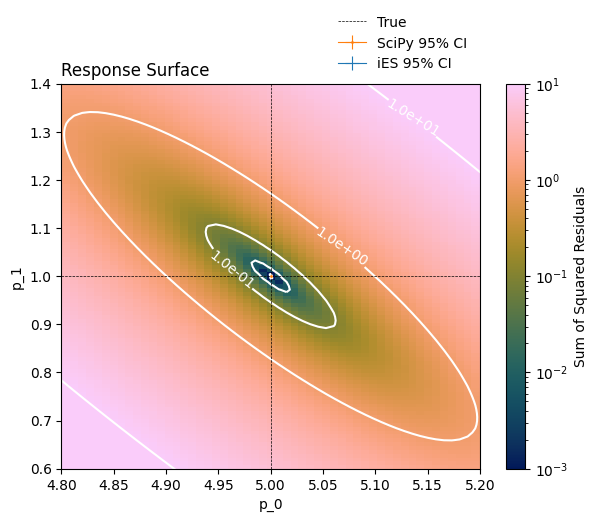

In [13]:
f, ax = plt.subplots(figsize=(6.75, 5.0))
ax.set_xlim(4.8, 5.2)
ax.set_ylim(0.6, 1.4)
plot_response_surface(P0, P1, RSS, vmin=1e-3, vmax=1e1, ax=ax)
ax.axhline(a, color="k", linewidth=0.5, linestyle="--", label="True")
ax.axvline(b, color="k", linewidth=0.5, linestyle="--")

traj_kwargs = {
    "color": "w",
    "marker": ".",
    "linewidth": 0.5,
    "markersize": 2.0,
    "alpha": 0.2,
}
# for real in ds["par"].real_name.values:
#     ax.plot(
#         ds["par"].sel(pname="p_0", real_name=real),
#         ds["par"].sel(pname="p_1", real_name=real),
#         **traj_kwargs,
#     )
ax.plot(
    ds["par"].isel(iteration=-1).sel(pname="p_0"),
    ds["par"].isel(iteration=-1).sel(pname="p_1"),
    **traj_kwargs,
    linestyle="none",
)

sp_ci = ml_sp.solver.ci()
ax.errorbar(
    x=ml_sp.p_0,
    y=ml_sp.p_1,
    xerr=sp_ci[0],
    yerr=sp_ci[1],
    linewidth=0.8,
    marker="o",
    markersize=1.0,
    color="C1",
    label="SciPy 95% CI",
)

ies_ci = ds["par"].isel(iteration=-1).quantile([0.025, 0.975], "real_name").values
ies_base = ds["par"].isel(iteration=-1).sel(real_name="base").values
ax.errorbar(
    x=ies_base[0],
    y=ies_base[1],
    xerr=np.abs(ies_ci[:, [0]] - ies_base[0]),
    yerr=np.abs(ies_ci[:, [1]] - ies_base[1]),
    color="C0",
    linewidth=0.8,
    label="iES 95% CI",
)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 1.0), frameon=False)

#### Loss function

SciPy Phi: 2.00e-28


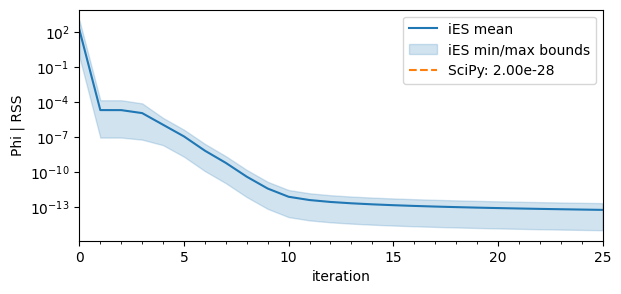

In [14]:
f, ax = plt.subplots(figsize=(6.75, 3.0))
ax.plot(ds["phi"].mean("real_name") / weight**2, label="iES mean")
ax.fill_between(
    ds["phi"].iteration,
    ds["phi"].min("real_name") / weight**2,
    ds["phi"].max("real_name") / weight**2,
    color="C0",
    alpha=0.2,
    label="iES min/max bounds",
)
print(f"SciPy Phi: {ml_sp.rss():.2e}")
# ax.axhline(ml_sp.rss(), color="C1", linestyle="--", label="SciPy RSS")
ax.plot([], [], color="C1", linestyle="--", label=f"SciPy: {ml_sp.rss():0.2e}")
ax.semilogy()
ax.set(
    xlim=(0, ml_ies_pp.noptmax),
    # ylim=(1e-4, 1e2),
    ylabel="Phi | RSS",
    xlabel="iteration",
)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5.0))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.legend()

The fit for both iES is still a lot larger than SciPy but the outcomes are pretty much the same. The CI is basically zero for both.

## Case 2: noise on observations

In [15]:
noise_std = 0.05  # noise level
y_n = LinRegModel.synthetic(p_0=b, p_1=a, x=x, noise_std=noise_std)

### Solve model

#### SciPy

In [16]:
ml_sp_n = LinRegModel(y_n)
ml_sp_n.add_solver(LinRegSolver())
ml_sp_n.solve()
ml_sp_n.parameters

,initial,pmin,pmax,optimal,vary
parnames,,,,,
p_0,5.501794,3.63682,7.386489,5.015022,True
p_1,1.000000,-1.00000,3.000000,0.973545,True


#### PEST++ iES

We give iES the same noise standard deviation as the true noise. 

In [17]:
path = Path("scenarios/linreg_noise")
path.mkdir(parents=True, exist_ok=True) if not path.exists() else None

ml_ies_n = LinRegModel(y_n)
ies_solver_n = PestIesSolver(
    exe_name=exe_name,
    model_ws=path / "ies_model",
    temp_ws=path / "ies_template",
    noptmax=noptmax,
    ies_num_reals=num_reals,
    control_data={},
)
ml_ies_n.add_solver(ies_solver_n)
ml_ies_n.solver.initialize()
ml_ies_n.solver.pf.pst.observation_data["weight"] = weight
ml_ies_n.solver.write_pst(ml_ies_n.solver.pf.pst, version=2)
ml_ies_n.solver.run_ensembles(
    pestpp_options=pestpp_ies_options,
    observation_noise_standard_deviation=noise_std,  # sets ies_no_noise to True if 0.0
)

# load pest ies results in an xarray dataset
ml_ies_pp_n = PestIesPostProcessor(ml_ies_n.solver.temp_ws)
ds_n = ml_ies_pp_n.load_dataset(rename=True)
ds_n

2025-09-30 16:36:51.679580 starting: opening PstFrom.log for logging
2025-09-30 16:36:51.679770 starting PstFrom process
2025-09-30 16:36:51.679806 starting: setting up dirs
2025-09-30 16:36:51.683855 starting: removing existing new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template'
2025-09-30 16:36:51.691695 finished: removing existing new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template' took: 0:00:00.007840
2025-09-30 16:36:51.691821 starting: copying original_d '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_model' to new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template'
2025-09-30 16:36:51.694790 finished: copying original_d '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_model' to new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template' took: 0:00:00.002969
2025-09-30 16:36:51.696415 finished: setting up dirs took: 0:00:00.016609


2025-09-30 16:36:51.704459 starting: adding grid type d style parameters for file(s) ['parameters_sel.csv']
2025-09-30 16:36:51.704612 starting: loading list-style /home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template/parameters_sel.csv
2025-09-30 16:36:51.704729 starting: reading list-style file: /home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template/parameters_sel.csv
2025-09-30 16:36:51.706427 finished: reading list-style file: /home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template/parameters_sel.csv took: 0:00:00.001698
2025-09-30 16:36:51.706536 loaded list-style '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template/parameters_sel.csv' of shape (2, 2)
2025-09-30 16:36:51.707555 finished: loading list-style /home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template/parameters_sel.csv took: 0:00:00.002943
2025-09-30 16:36:51.708295 starting: writing list-style template file '/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_temp

/home/vonkm/repos/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-09-30 16:36:51.732563 WARNING: add_py_function() command: run() is not being called directly



noptmax:0, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.16
binary compiled on Dec  1 2024 at 10:51:08

started at 09/30/25 16:36:51
...processing command line: ' ./pestpp-ies pest.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "pest.pst"
in directory: "/home/vonkm/repos/pestas/src/scenarios/linreg_noise/ies_template"
on host: "asuszbs14"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :' 

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/pytho

2025-09-30 16:36:52.406518 : trying to connect to localhost:4004...
2025-09-30 16:36:52.417305 : trying to connect to localhost:4004...
2025-09-30 16:36:52.431882 : trying to connect to localhost:4004...


/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.


2025-09-30 16:36:52.457594 : trying to connect to localhost:4004...
2025-09-30 16:36:52.482627 : trying to connect to localhost:4004...
2025-09-30 16:36:52.485412 : trying to connect to localhost:4004...2025-09-30 16:36:52.488490 : trying to connect to localhost:4004...

2025-09-30 16:36:52.526999 : trying to connect to localhost:4004...
2025-09-30 16:36:52.688166 : connected to localhost:4004
2025-09-30 16:36:52.704440 : connected to localhost:4004
2025-09-30 16:36:52.714446 : connected to localhost:4004
2025-09-30 16:36:52.723606 : connected to localhost:4004
2025-09-30 16:36:52.745847 : connected to localhost:4004
2025-09-30 16:36:52.752487 : connected to localhost:4004
2025-09-30 16:36:52.759138 : connected to localhost:4004
2025-09-30 16:36:52.789512 : connected to localhost:4004
09/30 16:37:03 remaining file transfers: 0                                       

   251 runs complete :  0 runs failed
   0.00638 avg run time (min) : 0.193 run mgr time (min)
   8 agents connected


..

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/pytho

<xarray.Dataset> Size: 2MB
Dimensions:       (iteration: 10, real_name: 251, pname: 2, oname: 101)
Coordinates:
  * iteration     (iteration) int64 80B 0 1 2 3 4 5 6 7 8 9
  * real_name     (real_name) object 2kB '0' '1' '2' '3' ... '248' '249' 'base'
  * pname         (pname) <U3 24B 'p_0' 'p_1'
  * oname         (oname) datetime64[ns] 808B 1970-01-01 ... 1970-01-01T00:00...
Data variables:
    par           (iteration, real_name, pname) float64 40kB 5.518 ... 0.9735
    obs           (iteration, real_name, oname) float64 2MB 5.518 ... 5.989
    phi           (iteration, real_name) float64 20kB 2.262e+13 ... 2.604e+11
    observations  (real_name, oname) float64 203kB 5.025 5.021 ... 5.905 5.97
    weights       (real_name, oname) float64 203kB 1e+06 1e+06 ... 1e+06 1e+06

### Results

#### Simulated values

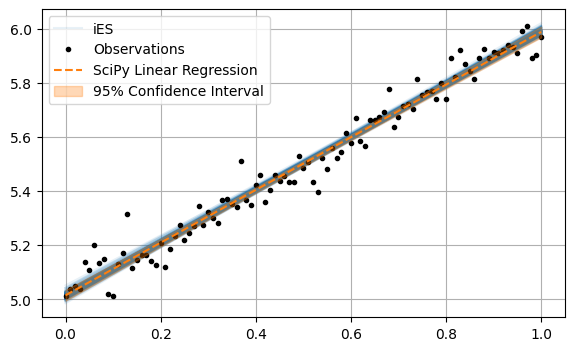

In [18]:
fig, ax = plt.subplots(figsize=(6.75, 4.0))
ax.plot(
    y_n.index,
    ds_n["obs"].isel(iteration=-1).values.T,
    color="C0",
    alpha=0.1,
    label="iES",
)
ax.plot(x, y_n, label="Observations", color="k", marker=".", linestyle="none")
ax.plot(
    x, ml_sp_n.simulate(), color="C1", linestyle="--", label="SciPy Linear Regression"
)
lower_bound, upper_bound = ml_sp_n.solver.ci_sim()
ax.fill_between(
    x,
    lower_bound,
    upper_bound,
    color="C1",
    alpha=0.3,
    label=f"{0.95:0.0%} Confidence Interval",
    zorder=10,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-4:], labels[-4:])
ax.grid(True)

#### Parameter estimates

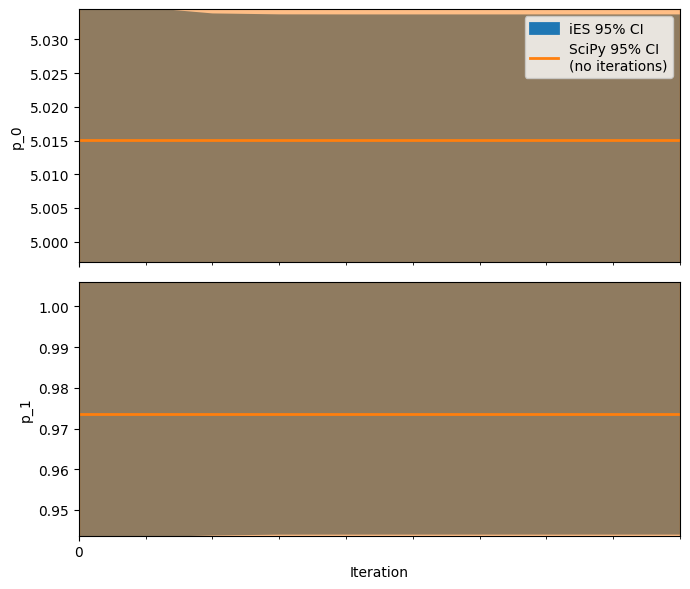

In [19]:
mosaic = [["p_0"], ["p_1"]]
f, axd = plt.subplot_mosaic(
    mosaic,
    figsize=(7.0, 6.0),
    sharex=True,
    layout="tight",
)
scipy_ci = ml_sp_n.solver.ci()
for i, pname in enumerate(axd):
    par = ds_n["par"].sel(pname=pname)
    parq = par.quantile(
        [0.025, 0.975], dim="real_name", skipna=True
    )  # .values.reshape(2, -1)
    axd[pname].fill_between(
        parq["iteration"],
        parq.values[0],
        parq.values[1],
        color="C0",
        label="iES 95% CI",
        linewidth=2.0,
    )

    scipy_opt = ml_sp_n.parameters.at[pname, "optimal"]
    axd[pname].axhline(
        scipy_opt,
        color="C1",
        alpha=1.0,
        linewidth=2.0,
        label="SciPy 95% CI\n(no iterations)",
    )
    axd[pname].fill_between(
        x=[0.0, ml_ies_pp_n.noptmax],
        y1=[scipy_opt - scipy_ci[i], scipy_opt - scipy_ci[i]],
        y2=[scipy_opt + scipy_ci[i], scipy_opt + scipy_ci[i]],
        color="C1",
        alpha=0.5,
    )
    axd[pname].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10.0))
    axd[pname].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
    axd[pname].set_ylim(parq.sel(iteration=1))
    axd[pname].set_ylabel(pname)
    axd[pname].set_xlabel("Iteration") if "p_1" in pname else None
    axd[pname].set_xlim(0, ml_ies_pp_n.noptmax)
axd["p_0"].legend()

#### Response surface

In [20]:
P0_n, P1_n, RSS_n = get_response_surface(ml_sp_n, 500)

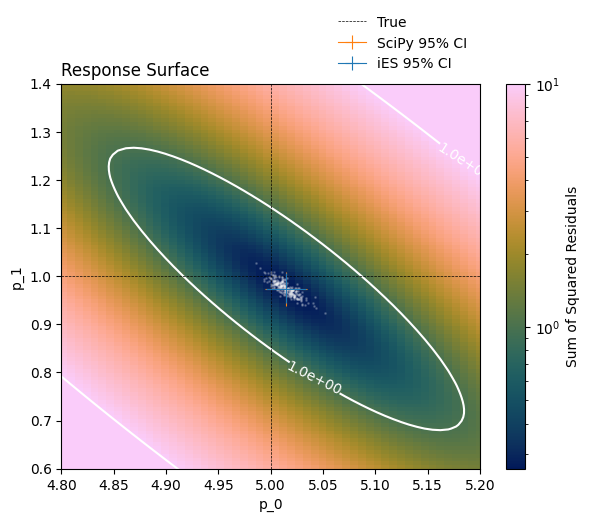

In [21]:
f, ax = plt.subplots(figsize=(6.75, 5.0))
ax.set(
    xlim=(4.8, 5.2),
    ylim=(0.6, 1.4),
)
plot_response_surface(P0_n, P1_n, RSS_n, vmin=np.min(RSS_n), vmax=1e1, ax=ax)
ax.axhline(a, color="k", linewidth=0.5, linestyle="--", label="True")
ax.axvline(b, color="k", linewidth=0.5, linestyle="--")

traj_kwargs = {
    "color": "w",
    "marker": ".",
    "linewidth": 0.5,
    "markersize": 2.0,
    "alpha": 0.2,
}
# for real in ds_n["par"].real_name.values:
#     ax.plot(
#         ds_n["par"].sel(pname="p_0", real_name=real),
#         ds_n["par"].sel(pname="p_1", real_name=real),
#         **traj_kwargs,
#     )
ax.plot(
    ds_n["par"].isel(iteration=-1).sel(pname="p_0"),
    ds_n["par"].isel(iteration=-1).sel(pname="p_1"),
    **traj_kwargs,
    linestyle="none",
)

sp_ci = ml_sp_n.solver.ci()
ax.errorbar(
    x=ml_sp_n.p_0,
    y=ml_sp_n.p_1,
    xerr=sp_ci[0],
    yerr=sp_ci[1],
    linewidth=0.8,
    color="C1",
    label="SciPy 95% CI",
)

ies_ci = ds_n["par"].isel(iteration=-1).quantile([0.025, 0.975], "real_name").values
ies_base = ds_n["par"].isel(iteration=-1).sel(real_name="base").values
ax.errorbar(
    x=ies_base[0],
    y=ies_base[1],
    xerr=np.abs(ies_ci[:, [0]] - ies_base[0]),
    yerr=np.abs(ies_ci[:, [1]] - ies_base[1]),
    color="C0",
    linewidth=0.8,
    label="iES 95% CI",
)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 1.0), frameon=False)

Outcomes are pretty similar for iES and SciPy again. The confidence intervals look pretty much the same.

#### Loss function

Loss function in PEST++ iES

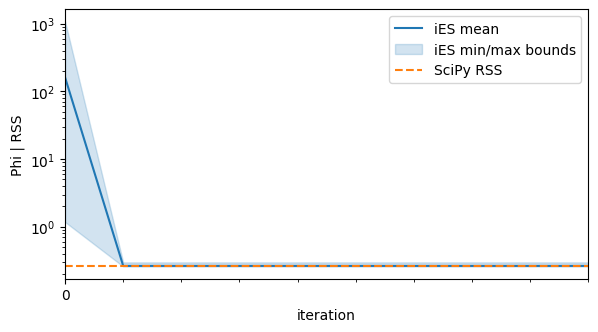

In [22]:
f, ax = plt.subplots(figsize=(6.75, 3.5))
ax.plot(ds_n["phi"].mean("real_name") / weight**2, label="iES mean")
ax.fill_between(
    ds_n["phi"].iteration,
    ds_n["phi"].min("real_name") / weight**2,
    ds_n["phi"].max("real_name") / weight**2,
    color="C0",
    alpha=0.2,
    label="iES min/max bounds",
)
ax.axhline(ml_sp_n.rss(), color="C1", linestyle="--", label="SciPy RSS")
ax.set(
    xlim=(0, ml_ies_pp_n.noptmax),
    # ylim=(2e-1, 1e0),
    ylabel="Phi | RSS",
    xlabel="iteration",
)
ax.semilogy()
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10.0))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))

ax.legend()

## Case 3: noise on observations but not on iES realizations

### Solve model

#### PEST++ iES

In [23]:
path = Path("scenarios/linreg_nnoise")
path.mkdir(parents=True, exist_ok=True) if not path.exists() else None

ml_ies_nn = LinRegModel(y_n)
ies_solver_nn = PestIesSolver(
    exe_name=exe_name,
    model_ws=path / "ies_model",
    temp_ws=path / "ies_template",
    noptmax=noptmax,
    ies_num_reals=num_reals,
    control_data={},
)
ml_ies_nn.add_solver(ies_solver_nn)
ml_ies_nn.solver.initialize()
ml_ies_nn.solver.pf.pst.observation_data["weight"] = weight
ml_ies_nn.solver.write_pst(ml_ies_nn.solver.pf.pst, version=2)
ml_ies_nn.solver.run_ensembles(
    pestpp_options=pestpp_ies_options,
    observation_noise_standard_deviation=0.0,  # sets ies_no_noise to True if 0.0
)

# load pest ies results in an xarray dataset
ml_ies_pp_nn = PestIesPostProcessor(ml_ies_nn.solver.temp_ws)
ds_nn = ml_ies_pp_nn.load_dataset(rename=True)
ds_nn

2025-09-30 16:39:40.057990 starting: opening PstFrom.log for logging
2025-09-30 16:39:40.058342 starting PstFrom process
2025-09-30 16:39:40.059417 starting: setting up dirs
2025-09-30 16:39:40.060193 starting: removing existing new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_template'
2025-09-30 16:39:40.069738 finished: removing existing new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_template' took: 0:00:00.009545
2025-09-30 16:39:40.069866 starting: copying original_d '/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_model' to new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_template'
2025-09-30 16:39:40.071170 finished: copying original_d '/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_model' to new_d '/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_template' took: 0:00:00.001304
2025-09-30 16:39:40.072374 finished: setting up dirs took: 0:00:00.012957
2025-09-30 16:39:40.081383 starting: adding grid type d 

/home/vonkm/repos/pyemu/pyemu/logger.py:100: PyemuWarning: 2025-09-30 16:39:40.111903 WARNING: add_py_function() command: run() is not being called directly



noptmax:0, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101
noptmax:25, npar_adj:2, nnz_obs:101


             pestpp-ies: a GLM iterative ensemble smoother

                   by the PEST++ development team


version: 5.2.16
binary compiled on Dec  1 2024 at 10:51:08

started at 09/30/25 16:39:40
...processing command line: ' ./pestpp-ies pest.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "pest.pst"
in directory: "/home/vonkm/repos/pestas/src/scenarios/linreg_nnoise/ies_template"
on host: "asuszbs14"

processing control file pest.pst


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.   :::. :
   `  :'

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/pytho

2025-09-30 16:39:40.762487 : trying to connect to localhost:4004...2025-09-30 16:39:40.777269 : trying to connect to localhost:4004...


/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.
/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.



2025-09-30 16:39:40.789547 : trying to connect to localhost:4004...
2025-09-30 16:39:40.811780 : trying to connect to localhost:4004...


/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.


2025-09-30 16:39:40.837351 : trying to connect to localhost:4004...
2025-09-30 16:39:40.858546 : trying to connect to localhost:4004...
2025-09-30 16:39:40.876425 : trying to connect to localhost:4004...
2025-09-30 16:39:40.891602 : trying to connect to localhost:4004...
2025-09-30 16:39:41.024657 : connected to localhost:4004
2025-09-30 16:39:41.040836 : connected to localhost:4004
2025-09-30 16:39:41.044739 : connected to localhost:4004
2025-09-30 16:39:41.080010 : connected to localhost:4004
2025-09-30 16:39:41.099954 : connected to localhost:4004
2025-09-30 16:39:41.117826 : connected to localhost:4004
2025-09-30 16:39:41.130899 : connected to localhost:4004
2025-09-30 16:39:41.145502 : connected to localhost:4004
09/30 16:39:50 remaining file transfers: 0                                       

   251 runs complete :  0 runs failed
   0.00347 avg run time (min) : 0.169 run mgr time (min)
   8 agents connected


...saved initial obs ensemble to pest.0.obs.csv
saved par and rei file

/home/vonkm/.local/share/uv/python/cpython-3.13.5-linux-x86_64-gnu/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=274580) is multi-threaded, use of fork() may lead to deadlocks in the child.


<xarray.Dataset> Size: 6MB
Dimensions:       (iteration: 26, real_name: 251, pname: 2, oname: 101)
Coordinates:
  * iteration     (iteration) int64 208B 0 1 2 3 4 5 6 ... 19 20 21 22 23 24 25
  * real_name     (real_name) object 2kB '0' '1' '2' '3' ... '248' '249' 'base'
  * pname         (pname) <U3 24B 'p_0' 'p_1'
  * oname         (oname) datetime64[ns] 808B 1970-01-01 ... 1970-01-01T00:00...
Data variables:
    par           (iteration, real_name, pname) float64 104kB 5.518 ... 0.9735
    obs           (iteration, real_name, oname) float64 5MB 5.518 ... 5.989
    phi           (iteration, real_name) float64 52kB 2.262e+13 ... 2.604e+11
    observations  (real_name, oname) float64 203kB 5.012 5.038 ... 5.905 5.97
    weights       (real_name, oname) float64 203kB 1e+06 1e+06 ... 1e+06 1e+06

### Results

#### Simulated values

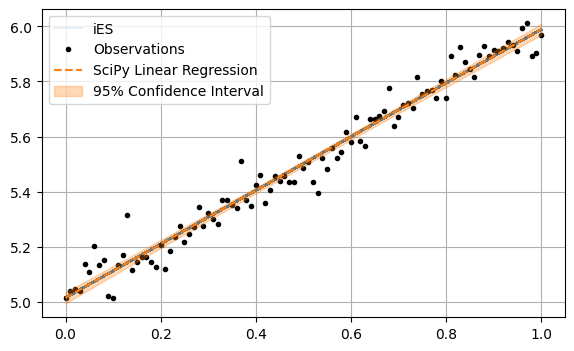

In [24]:
fig, ax = plt.subplots(figsize=(6.75, 4.0))
ax.plot(
    y_n.index,
    ds_nn["obs"].isel(iteration=-1).values.T,
    color="C0",
    alpha=0.1,
    label="iES",
)
ax.plot(x, y_n, label="Observations", color="k", marker=".", linestyle="none")
ax.plot(
    x, ml_sp_n.simulate(), color="C1", linestyle="--", label="SciPy Linear Regression"
)
lower_bound, upper_bound = ml_sp_n.solver.ci_sim()
ax.fill_between(
    x,
    lower_bound,
    upper_bound,
    color="C1",
    alpha=0.3,
    label=f"{0.95:0.0%} Confidence Interval",
    zorder=10,
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-4:], labels[-4:])
ax.grid(True)

#### Parameter estimates

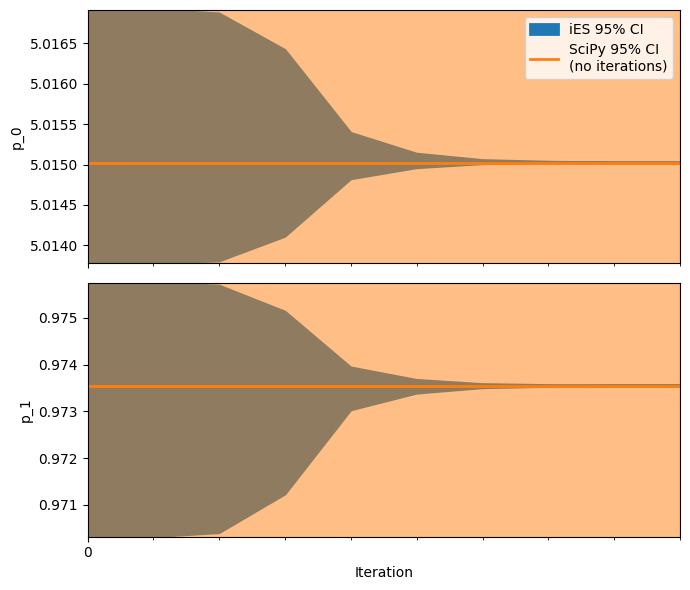

In [25]:
mosaic = [["p_0"], ["p_1"]]
f, axd = plt.subplot_mosaic(
    mosaic,
    figsize=(7.0, 6.0),
    sharex=True,
    layout="tight",
)
scipy_ci = ml_sp_n.solver.ci()
for i, pname in enumerate(axd):
    par = ds_nn["par"].sel(pname=pname)
    parq = par.quantile(
        [0.025, 0.975], dim="real_name", skipna=True
    )  # .values.reshape(2, -1)
    axd[pname].fill_between(
        parq["iteration"],
        parq.values[0],
        parq.values[1],
        color="C0",
        label="iES 95% CI",
        linewidth=2.0,
    )

    scipy_opt = ml_sp_n.parameters.at[pname, "optimal"]
    axd[pname].axhline(
        scipy_opt,
        color="C1",
        alpha=1.0,
        linewidth=2.0,
        label="SciPy 95% CI\n(no iterations)",
    )
    axd[pname].fill_between(
        x=[0.0, ml_ies_pp_n.noptmax],
        y1=[scipy_opt - scipy_ci[i], scipy_opt - scipy_ci[i]],
        y2=[scipy_opt + scipy_ci[i], scipy_opt + scipy_ci[i]],
        color="C1",
        alpha=0.5,
    )
    axd[pname].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10.0))
    axd[pname].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
    axd[pname].set_ylim(parq.sel(iteration=1))
    axd[pname].set_ylabel(pname)
    axd[pname].set_xlabel("Iteration") if "p_1" in pname else None
    axd[pname].set_xlim(0, ml_ies_pp_n.noptmax)
axd["p_0"].legend()

#### Response surface

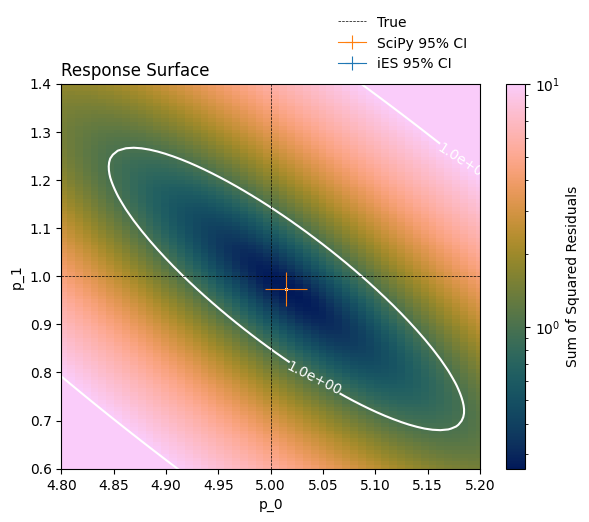

In [26]:
f, ax = plt.subplots(figsize=(6.75, 5.0))
ax.set(
    xlim=(4.8, 5.2),
    ylim=(0.6, 1.4),
)
plot_response_surface(P0_n, P1_n, RSS_n, vmin=np.min(RSS_n), vmax=1e1, ax=ax)
ax.axhline(a, color="k", linewidth=0.5, linestyle="--", label="True")
ax.axvline(b, color="k", linewidth=0.5, linestyle="--")

traj_kwargs = {
    "color": "w",
    "marker": ".",
    "linewidth": 0.5,
    "markersize": 2.0,
    "alpha": 0.2,
}
# for real in ds_n["par"].real_name.values:
#     ax.plot(
#         ds_n["par"].sel(pname="p_0", real_name=real),
#         ds_n["par"].sel(pname="p_1", real_name=real),
#         **traj_kwargs,
#     )
ax.plot(
    ds_nn["par"].isel(iteration=-1).sel(pname="p_0"),
    ds_nn["par"].isel(iteration=-1).sel(pname="p_1"),
    **traj_kwargs,
    linestyle="none",
)

sp_ci = ml_sp_n.solver.ci()
ax.errorbar(
    x=ml_sp_n.p_0,
    y=ml_sp_n.p_1,
    xerr=sp_ci[0],
    yerr=sp_ci[1],
    linewidth=0.8,
    color="C1",
    label="SciPy 95% CI",
)

ies_ci = ds_nn["par"].isel(iteration=-1).quantile([0.025, 0.975], "real_name").values
ies_base = ds_nn["par"].isel(iteration=-1).sel(real_name="base").values
ax.errorbar(
    x=ies_base[0],
    y=ies_base[1],
    xerr=np.abs(ies_ci[:, [0]] - ies_base[0]),
    yerr=np.abs(ies_ci[:, [1]] - ies_base[1]),
    color="C0",
    linewidth=0.8,
    label="iES 95% CI",
)
ax.legend(loc="lower right", bbox_to_anchor=(1.0, 1.0), frameon=False)

#### Loss function

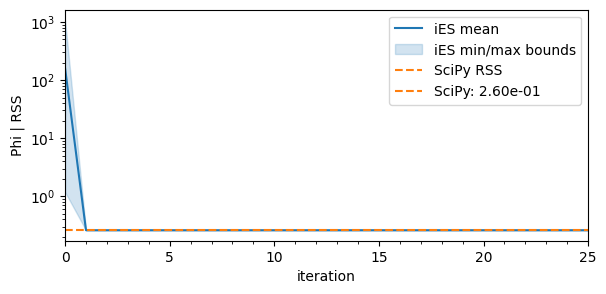

In [ ]:
f, ax = plt.subplots(figsize=(6.75, 3.0))
ax.plot(ds_nn["phi"].mean("real_name") / weight**2, label="iES mean")
ax.fill_between(
    ds_nn["phi"].iteration,
    ds_nn["phi"].min("real_name") / weight**2,
    ds_nn["phi"].max("real_name") / weight**2,
    color="C0",
    alpha=0.2,
    label="iES min/max bounds",
)
ax.axhline(ml_sp_n.rss(), color="C1", linestyle="--", label="SciPy RSS")
ax.semilogy()
ax.set(
    xlim=(0, ml_ies_pp.noptmax),
    # ylim=(1e-4, 1e2),
    ylabel="Phi | RSS",
    xlabel="iteration",
)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5.0))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.legend()

If no noise is added on the observations for each realizations. The confidence interval for PEST++ iES is too small and does not contain the true value anymore. 